# Medium Reinforcement Learning

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time

In [2]:
env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
env = gym.make(env_name).env

obs = env.reset()
# env.render()

In [3]:
env.action_space.n

3

In [4]:
# env.action_space.low, env.action_space.high

In [5]:
nv = env.unwrapped
env.seed()
np.random.seed(1)

In [6]:
n_states = 200
J = 100

## Functions

In [7]:
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled


In [8]:
def visualise_actions(mat):
    plt.figure(figsize = (5,5))
    labels = ["Move Left", "Don't Accelerate", "Move Right"]
    cmap = plt.cm.get_cmap('Blues', 8) 
    plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat[::-1, ::1], cmap = cmap)
    plt.xlabel("Position", fontsize = 15)
    plt.ylabel("Velocity", fontsize = 15)
    plt.title("Approximate Value Function", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
    plt.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
               [labels[i] for i in range(3)])

In [9]:
def visualise_conf(mat):
    plt.figure(figsize = (5,5))
    labels = ["Move Left", "Don't Accelerate", "Move Right"]
    cmap = plt.cm.get_cmap('Blues', 8) 
    plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat[::-1, ::-1], cmap = cmap)
    plt.xlabel("Position", fontsize = 15)
    plt.ylabel("Velocity", fontsize = 15)
    plt.title("Confidence Plot?", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
#     plt.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
#                [labels[i] for i in range(3)])

## TABULAR METHOD

In [10]:
def tabular_method(
    n_states = 40,
    episodes = 10000,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.95,
    max_stps = 100000,
    epsilon = 0.05):
    
    q_table = np.zeros((n_states, n_states, env.action_space.n))
#     q_table = np.zeros((n_states, n_states,1))# env.action_space.n))
    
    tabular_steps = []
    

    
    for episode in range(episodes):

        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))

        steps = 0
        while True:
    #         env.render()
            pos, vel = discretization(env, obs)
            pos, vel = int(pos), int(vel) # tabular method need ints
            if np.random.uniform(low=0, high=1) < epsilon:
#                 a = np.random.uniform(low = env.action_space.low, high = env.action_space.high)
                a = np.random.choice(env.action_space.n) #for discrete action space
            else:
#                 a = q_table[pos][vel]
                a = np.argmax(q_table[pos][vel])
            try:
                obs, reward, terminate,_ = env.step(a)
            except Exception as e:
                print("ACTION", a)
                
                print(e)
                return()
            total_reward += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs)
            pos_, vel_ = int(pos_), int(vel_)


            # Q function update
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))

#             update = (1-alpha)*q_table[pos][vel] + alpha*(reward+gamma*q_table[pos_][vel_])
#             if update > 1:
#                 update = 1
#             elif update < -1:
#                 update = -1

#             q_table[pos][vel] = update
            
            # value : the optimum action i can take is the reward that i get from taking that action + 
            # gamma x the optimum I can gather as value from where I go
            steps += 1
            if steps%max_stps == 0:
                print("FAILED")
                break
            if terminate:
                tabular_steps.append(steps)
                if episode % 100 == 0:
                    print("Episode:", episode, "Alpha: ", alpha, "Steps: ", steps)
                break

    env.close()
    return(q_table)

In [11]:
q_table = tabular_method(n_states)

FAILED
FAILED
FAILED
Episode: 100 Alpha:  0.95 Steps:  1110
Episode: 200 Alpha:  0.9025 Steps:  527
Episode: 300 Alpha:  0.8573749999999999 Steps:  749
Episode: 400 Alpha:  0.8145062499999999 Steps:  658
Episode: 500 Alpha:  0.7737809374999998 Steps:  578
Episode: 600 Alpha:  0.7350918906249998 Steps:  446
Episode: 700 Alpha:  0.6983372960937497 Steps:  564
Episode: 800 Alpha:  0.6634204312890623 Steps:  482
Episode: 900 Alpha:  0.6302494097246091 Steps:  362
Episode: 1000 Alpha:  0.5987369392383787 Steps:  414
Episode: 1100 Alpha:  0.5688000922764597 Steps:  367
Episode: 1200 Alpha:  0.5403600876626367 Steps:  442
Episode: 1300 Alpha:  0.5133420832795048 Steps:  398
Episode: 1400 Alpha:  0.48767497911552954 Steps:  598
Episode: 1500 Alpha:  0.46329123015975304 Steps:  438
Episode: 1600 Alpha:  0.44012666865176536 Steps:  516
Episode: 1700 Alpha:  0.4181203352191771 Steps:  491
Episode: 1800 Alpha:  0.3972143184582182 Steps:  566
Episode: 1900 Alpha:  0.37735360253530725 Steps:  485
Ep

In [12]:
# for e in range(100):
#     obs = env.reset()
#     steps = 0
#     while True:
#         env.render()
#         pos, vel = discretization(env, obs)
#         pos, vel = int(pos), int(vel)
# #         a = q_table[pos][vel]
#         a = np.argmax(q_table[pos][vel])
# #         a = int(m[pos][vel])
#         obs, reward, terminate, _ = env.step(a)
#         steps += 1

#         if steps >= 1000:
#             print("FAILED")
#             break
#         if terminate:
#             time.sleep(1)
#             print(steps)
#             break

In [13]:
mat = np.max(q_table, axis =2)
mat_actions = np.argmax(q_table, axis =2)

In [14]:
mat_actions.shape

(200, 200)

C:\conda_tmp/ipykernel_21628/4184196547.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat[::-1, ::1], cmap = cmap)


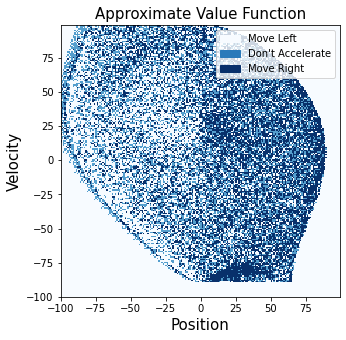

In [15]:
visualise_actions(mat_actions) #make gif of this

C:\conda_tmp/ipykernel_21628/776601333.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat[::-1, ::-1], cmap = cmap)


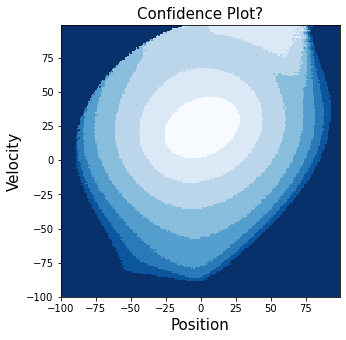

In [16]:
visualise_conf(mat)

# Gradient Descent

In [17]:
q_table.shape

(200, 200, 3)

In [18]:
def construct_states(n = n_states):
    states = []
    for i in range(n):
        for j in range(n):
            for k in range(3):
#                 print(i, j, k)
                states.append(np.array([i, j,k]))
    states = np.asarray(states)
    return(states)

In [19]:
# n_states = 100

In [20]:
states = construct_states(n_states)

In [21]:
states

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [199, 199,   0],
       [199, 199,   1],
       [199, 199,   2]])

In [22]:
def get_means(J):
    """
    Getting J cluster centers for the radial basis model
    """
#     print(df_values.shape)
    X = states #state space is the position, velocity and action
    means = []

    N = len(states)
    sig = np.std(X)
    
    for i in range(3):
        means.append(np.linspace(X[:, i].min(), X[:, i].max(), J))
    means  = np.array(means).T
    
    U = np.zeros((N,J))

    for i in range(N):
        for j in range(J):
            U[i][j] = np.exp(-0.5 *np.linalg.norm(X[i] - means[j])/(sig))
    
    return(U, means)

In [23]:
U, kmeans = get_means(J)

In [24]:
U.shape

(120000, 100)

In [25]:
def evaluate_a(pos, vel, a, w):
    """
    Getting the value from a state
    
    input: state, action, weights vector
    
    Output: value of action in that state
    
    Method: convert the state and action into the design matrix, then dot product the weights 
    
    """
    states = np.array([pos, vel, a])
    U = []
    for j in range(J):
        U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
    return(U @ w, U)

In [26]:
def RBF(pos, vel, w):
    """
    RBF for the values of all possible actions from that state
    
    """
    vals = []
    for act in range(3):
        U = []
        states = np.array([pos, vel, act])
        for j in range(J):
            U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
        vals.append(U @ w)
    return(vals)

## Q-learning

In [ ]:
# try neural network? train on gpu

In [27]:
def discretization(env, obs): #NO INT
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low)# / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled =(obs[0] - pos_low) / pos_den   #int((obs[0] - pos_low) / pos_den)
    vel_scaled = (obs[1] - vel_low) / vel_den#int((obs[1] - vel_low) / vel_den)
    return(pos_scaled, vel_scaled)

In [28]:
X = states #state space is the position, velocity and action
sig = np.std(X)

In [29]:
def q_learning(
    n_states = n_states,
    episodes = 50,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.99,
    max_stps = 30000,
    epsilon = 0.05):



    q_table = np.zeros((n_states, n_states, env.action_space.n))
    total_steps = []


    w = np.random.rand(J, 1)
    for episode in range(episodes):


        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode/0.1)))# max(min_lr, initial_lr*(gamma**(episode//100)))

        steps = 0
        while True:

            pos, vel = discretization(env, obs)

            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
                a_value, U = evaluate_a(pos, vel, a, w)
            else:
                a = np.argmax(RBF(pos, vel, w))
                a_value, U = evaluate_a(pos, vel, a, w)

            obs, reward, terminate,_ = env.step(a)
            total_reward += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs)

            states = np.array([pos, vel, a])

            max_val = np.max(RBF(pos_,vel_, w)) #random thing for sarsa

            # Q function update
            w += (alpha * (reward + gamma*max_val - a_value) * U).reshape(J,1)
            

            steps += 1
            if terminate:
                total_steps.append(steps)
                print("Episode:", episode, steps)
                break
    return(w)

In [30]:
w_q_learning = q_learning()

Episode: 0 21668
Episode: 1 10191
Episode: 2 12201
Episode: 3 11286
Episode: 4 10639
Episode: 5 40539
Episode: 6 8937
Episode: 7 18176
Episode: 8 4524
Episode: 9 7931
Episode: 10 44220
Episode: 11 5392
Episode: 12 29411
Episode: 13 18064
Episode: 14 11921
Episode: 15 34251
Episode: 16 7863
Episode: 17 20847
Episode: 18 14712
Episode: 19 9033
Episode: 20 37849
Episode: 21 38158
Episode: 22 7783
Episode: 23 26258
Episode: 24 35105
Episode: 25 5174
Episode: 26 15074
Episode: 27 7124
Episode: 28 47669
Episode: 29 16476
Episode: 30 35697
Episode: 31 5590
Episode: 32 35449
Episode: 33 24837
Episode: 34 2793
Episode: 35 32301
Episode: 36 12323
Episode: 37 22809
Episode: 38 9107
Episode: 39 9309


KeyboardInterrupt: 

In [ ]:
U.shape, w_q_learning.shape

In [ ]:
q_learning_table = np.zeros([n_states,n_states])
step = 0
for i in range(n_states):
    for j in range(n_states):
        q_learning_table[i][j] = np.argmax(U[step*3: step*3+3] @ w_q_learning)
        step += 1

In [ ]:
q_learning_table.shape

In [ ]:
visualise_actions(q_learning_table)

In [ ]:
# for e in range(100):
#     obs = env.reset()
#     steps = 0
#     while True:
# #         env.render()
#         pos, vel = discretization(env, obs)
#         pos, vel = int(pos), int(vel)
# #         a = q_table[pos][vel]
#         a = np.argmax(q_learning_table[pos][vel])
# #         a = int(m[pos][vel])
#         obs, reward, terminate, _ = env.step(a)
#         steps += 1

#         if steps >= 1000:
#             print("FAILED")
#             break
#         if terminate:
#             time.sleep(1)
#             print(steps)
#             break

In [ ]:
# for e in range(100):
#     obs = env.reset()
#     steps = 0
#     while True:
# #         env.render()
#         pos, vel = discretization(env, obs)
#         a = np.argmax(RBF(pos, vel, w_q_learning))

#         obs, reward, terminate, _ = env.step(a)
#         steps += 1

#         if steps >= 1000:
#             print("FAILED")
#             break
#         if terminate:
#             time.sleep(1)
#             print(steps)
#             break